# Preparação do corpus e pré-processamento

In [3]:
from google.colab import files
import glob

# arquivo = files.upload()
!unzip 'Enron.zip' -d 'enron'

Archive:  Enron.zip
replace enron/0001.1999-12-10.farmer.ham.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import nltk
nltk.download('stopwords')
stops = nltk.corpus.stopwords.words('english')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')


def tokenizar(str_texto):
    return word_tokenize(str_texto)

def limpar(lista):
    return [i.lower() for i in lista if i.isalpha()]

def sem_stops(lista):
    return [i for i in lista if i not in stops]

def stemizar(lista):
    return [stemmer.stem(i) for i in lista]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
arqs = glob.glob('enron/*.txt')
mensagens = list()
etiquetas = list()
for arq in arqs:
    arquivo = open(arq, 'r')
    classe = int(arquivo.readline()[0])  # Pega só o número e deixa de fora o \n
    
    texto = arquivo.read()
    texto = stemizar(sem_stops(limpar(tokenizar(texto))))
    mensagens.append(texto)
    etiquetas.append(classe)
    arquivo.close()

In [6]:
# Conferindo...
etiquetas[:10]

[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]

# Codificação (encoding)

In [7]:
import numpy as np

vocab = set([p for sent in mensagens for p in sent])

# Cria um dicionário {palavra: índice}
indices_de_palavras = {palavra: e+1 for e, palavra in enumerate(vocab)}  # e+1 para que o primeiro índice não seja 0, que é um pad

# Gera um vetor de índices de palavras para cada mensagem
vetores_msg = np.array([[indices_de_palavras[p] for p in d] for d in mensagens], dtype=object)
vetores_msg

array([list([29861, 16984, 30595, 33700, 4534, 27977, 1698, 22052, 26454, 17536, 36742, 13466, 17537, 17537, 11832, 36831, 35491, 19507, 23844, 24623, 11572, 37248, 758, 30421, 27566, 7305, 27566, 22042, 27566, 11832, 18679, 36742, 27472, 19947, 27373]),
       list([29861, 19754, 16063, 20676, 18594, 17311, 5440, 15655, 29646, 37721, 17722, 36133, 35342, 24971, 3412, 23818, 1815, 5440, 18594, 17311, 28370, 8231, 17311, 29589, 24880, 8423, 6757, 33552, 26041, 33844, 11547, 37691, 32131, 28403, 19507, 2263, 33552, 35943, 12649, 23031, 19254, 1659, 24880, 8423, 6757, 12153, 17311, 1659, 26063, 17311, 35342, 20118, 8972, 37391, 8071, 28397]),
       list([29861, 31390, 11447, 37672, 31031, 19947, 24283, 5576, 11377, 11447, 37672, 33416, 31031, 1227, 33849, 31031, 21116, 5189, 5607, 18358, 33984, 19947, 24283, 8423, 10078, 10526, 32281, 31031, 9488, 29138, 8240, 11917, 19947, 17931, 10078, 29205, 10526, 32281, 19045, 23469, 13304, 25390, 4541, 15519, 26980, 24367, 34786, 24283, 749, 9813, 

In [8]:
# Conferindo...
print(len(vocab))
indices_de_palavras['viagra']

37892


31427

# Sua vez: conversão para vetores binários

In [9]:
def binarizar(matriz_int, dim):
    binarizado = np.zeros((len(matriz_int), dim))

    for e, vetor in enumerate(matriz_int):
        binarizado[e, vetor] = 1.

    return binarizado

# Conversão em binários dos testos das resenhas (variável X)
vetores_msg_bin = binarizar(vetores_msg, dim=len(vocab)+1)

In [10]:
# Conferindo...
print(vetores_msg_bin.shape)
vetores_msg_bin[0]

(5157, 37893)


array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
# Binarização das etiquetas de classificação. Variável Y.

etiquetas_bin = np.asarray(etiquetas).astype('float32')

In [12]:
# Conferindo...
etiquetas_bin[:10] 

array([1., 0., 1., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

# Sua vez: partição dos dados em treinamento / teste

In [13]:
# Partição treinamento / teste
treino_x = vetores_msg_bin[:round(len(mensagens) * 0.8)]
teste_x = vetores_msg_bin[round(len(mensagens) * 0.8):]

treino_y = etiquetas_bin[:len(treino_x)]
teste_y = etiquetas_bin[len(treino_y):]

In [14]:
print(treino_x.shape)
print(teste_x.shape)
print(treino_y.shape)
print(teste_y.shape)

(4126, 37893)
(1031, 37893)
(4126,)
(1031,)


In [15]:
len(mensagens)

5157

# Criação do modelo de rede

Partição dos dados de treinamento em (1) validação e (2) treinamento parcial, tanto X (resenhas) quanto Y (etiquetas).

In [16]:
valid_x = treino_x[:2000]
treino_x_parcial = treino_x[2000:]
valid_y = treino_y[:2000] 
treino_y_parcial = treino_y[2000:]

# Sua vez 

Determine os parâmetros faltantes na arquitetura do modelo: forma da camada de entrada e tamanho da camada de saída.

In [17]:
from keras import models 
from keras import layers

modelo = models.Sequential() 
modelo.add(layers.Dense(16, activation='relu', input_shape=(37893,)))
modelo.add(layers.Dense(16, activation='relu'))
modelo.add(layers.Dense(1, activation='sigmoid'))

In [18]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                606304    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 606,593
Trainable params: 606,593
Non-trainable params: 0
_________________________________________________________________


# Sua vez

Preencha os parâmetros para a compilação do modelo de acordo com a informação do comentário.

In [19]:
# A função de perda escolhida é a entropia cruzada, boa para classificação probabilística,
# e binária, pois temos duas classes possíveis para as etiquetas das resenhas (pos. e neg.)
# O otimizador é o Adam, sempre uma boa escolha para PLN.
# O desempenho será avaliado pela acurácia ("acc").

modelo.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics='acc')

Treinamento do modelo compilado.

In [20]:
historia = modelo.fit(treino_x_parcial, 
                    treino_y_parcial, 
                    epochs=30, 
                    batch_size=512, 
                    validation_data=(valid_x, valid_y), 
                    verbose=0  # já que será gerado um gráfico, não é tão importante ver os números do aprendizado
                    )

Exibição da evolução da perda no treinamento e na validação.

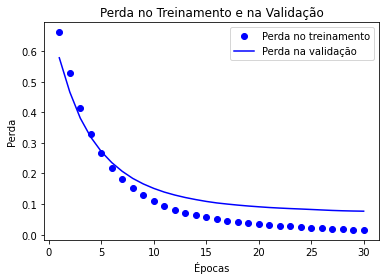

In [21]:
import matplotlib.pyplot as plt

dic_historia = historia.history  # dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
perda = dic_historia['loss'] 
perda_valid = dic_historia['val_loss']

acuracia = dic_historia['acc']
epocas = range(1, len(acuracia) + 1)

plt.plot(epocas, perda, 'bo', label='Perda no treinamento')  # “bo” = pontilhado azul
plt.plot(epocas, perda_valid, 'b', label='Perda na validação')  # “b” = linha contínua azul
plt.title('Perda no Treinamento e na Validação') 
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.show()

Exibição da evolução da acurácia no teste e na validação.

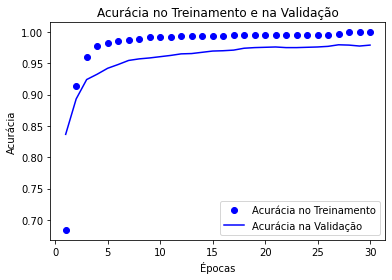

In [22]:
plt.clf()  # Limpa a figura

acuracia_treino = dic_historia['acc'] 
acuracia_valid = dic_historia['val_acc']

plt.plot(epocas, acuracia_treino, 'bo', label='Acurácia no Treinamento') 
plt.plot(epocas, acuracia_valid, 'b', label='Acurácia na Validação')
plt.title('Acurácia no Treinamento e na Validação') 
plt.xlabel('Épocas') 
plt.ylabel('Acurácia') 
plt.legend()

plt.show()

# Treinamento com `EarlyStopping`

O modelo será treinado novamente com um número grande de épocas, em busca de obter seu melhor desempenho e parar quando encontrá-lo "automaticamente", isto é, quando parar de ter melhoria no aprendizado.


In [23]:
from tensorflow.keras import callbacks

aprendeu_parou = callbacks.EarlyStopping(
    min_delta=0.001,  # aprendizado mínimo (resultados menores não contarão como aprendizado)
    patience=10,  # por quantas épocas insistir?
    restore_best_weights=True,
)

historia = modelo.fit(treino_x_parcial, 
                    treino_y_parcial, 
                    epochs=300, 
                    batch_size=512, 
                    validation_data=(valid_x, valid_y),
                    callbacks=[aprendeu_parou])

Epoch 1/300
5/5 [==============================] - 1s 166ms/step - loss: 0.0144 - acc: 0.9995 - val_loss: 0.0763 - val_acc: 0.9795
Epoch 2/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0133 - acc: 0.9995 - val_loss: 0.0759 - val_acc: 0.9790
Epoch 3/300
5/5 [==============================] - 1s 122ms/step - loss: 0.0124 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9790
Epoch 4/300
5/5 [==============================] - 1s 120ms/step - loss: 0.0116 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9785
Epoch 5/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0109 - acc: 1.0000 - val_loss: 0.0755 - val_acc: 0.9785
Epoch 6/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0102 - acc: 1.0000 - val_loss: 0.0756 - val_acc: 0.9785
Epoch 7/300
5/5 [==============================] - 1s 123ms/step - loss: 0.0096 - acc: 1.0000 - val_loss: 0.0757 - val_acc: 0.9780
Epoch 8/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0091 - a

# Sua vez

Preencha os parâmetros da função de avaliação. 

In [24]:
avaliacao = modelo.evaluate(teste_x, teste_y)

33/33 [==============================] - 0s 3ms/step - loss: 0.0657 - acc: 0.9845


In [25]:
print('Acurácia na avaliação: ', avaliacao[1], '\nPerda: ', avaliacao[0])

Acurácia na avaliação:  0.9844810962677002 
Perda:  0.06570498645305634


# Playground!

Experimente mudar a arquitetura da rede (tamanho e profundidade de camadas) para ver se são produzidas diferenças nos resultados.

E que tal mudar:

* A função de perda para `mse` (erro quadrático médio)
* A função de ativação para `tanh` (tangente hiperbólica) ao invés de `relu`

Use `EarlyStopping` para limitar o número de épocas de aprendizado.

In [26]:
from plotly import graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
from plotly.io import to_html

In [30]:
def build_model(units, activation, loss, optimizer):
    modelo = models.Sequential()
    for i in range(len(units)):
        modelo.add(layers.Dense(units[i], activation=activation, input_shape=(37893,)))
    
    modelo.add(layers.Dense(1, activation='sigmoid'))
    modelo.compile(optimizer=optimizer, 
            loss=loss, 
            metrics='acc')
    return modelo
def train_model(modelo):
    aprendeu_parou = callbacks.EarlyStopping(
        min_delta=0.001,  
        patience=5,  
        restore_best_weights=True,
    )

    historia = modelo.fit(
        treino_x_parcial, 
        treino_y_parcial, 
        epochs=200, 
        batch_size=512, 
        validation_data=(valid_x, valid_y),
        callbacks=[aprendeu_parou],
        verbose=0
    )
    return historia
    
def plot_results(historia):

    dic_historia = historia.history  # dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
    perda_treino = dic_historia['loss']
    perda_valid = dic_historia['val_loss']

    acuracia_treino = dic_historia['acc'] 
    acuracia_valid = dic_historia['val_acc']
    epocas = range(1, len(acuracia_treino) + 1)
    tmp = pd.DataFrame({
        "Epocas":epocas,
        "Acurácia_Treino":acuracia_treino,
        "Acurácia_Validação":acuracia_valid,
        "Custo_Treino":perda_treino,
        "Custo_Validação":perda_valid,
    })

    fig = make_subplots(rows=2, cols=1,
        subplot_titles=("Acurácia por Épocas", "Custo por Épocas"))

    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Acurácia_Validação"],
            name="Acurácia Validação"
        ),
        row=1,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Acurácia_Treino"],
            name="Acurácia Treino"
        ),
        row=1,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Custo_Validação"],
            name="Custo Validação"
        ),
        row=2,
        col=1
    )
    fig.add_trace(
        go.Scatter(
            x=tmp['Epocas'],
            y=tmp["Custo_Treino"],
            name="Custo Treino"
        ),
        row=2,
        col=1
    )
    fig.update_xaxes(title_text="Épocas", row=1, col=1)
    fig.update_xaxes(title_text="Épocas", row=2, col=1)
    fig.update_yaxes(title_text="Acurácia", row=1, col=1, range=[0, 1])
    fig.update_yaxes(title_text="Custo", row=2, col=1, range=[0, 1])
    fig.update_layout(height=1200, width=800)
    fig_html = to_html(fig, full_html=False)
    return fig_html

def build_report(historia, hiperparams, modelo, teste_x, teste_y, first_run=False, last_run=False):
    if first_run:
        fl = open("process-report.html", 'w')
        fl.write("""
        <html>
            <head>
                <meta charset="UTF-8">
                <style>
                .plotly-graph-div {
                    margin: 0 auto;
                }
                </style>
            </head>
            <body>
                <h1 align=\'center\'>Report do processo de busca do melhor modelo</h1>
                <hr>
        """)
    else:
        fl = open('process-report.html', 'a')
        fl.write("<hr>")

    fl.write("""
    <h2 align=\'center\'>Hiper parâmetros do modelo</h2>
    <div align=\'center\'>
    """)
    for hiperparam in hiperparams:
        fl.write(str(hiperparam) + ": " + str(hiperparams[hiperparam]) + "<br>")
    
    avaliacao = modelo.evaluate(teste_x, teste_y)
    fl.write(f'''
    Acurácia na avaliação: {str(avaliacao[1])} <br>
    Perda: {str(avaliacao[0])}
    </div>
    ''')
    fig_html = plot_results(historia)
    fl.write(fig_html)
    if last_run:
        fl.write("""
        </body>
        </html>        
        """)
    fl.close()
    

In [31]:
hiperparams_grid = {
    "units":[[32, 64, 8], [16, 16], [8], [32, 32, 32, 32, 32]],
    "activations":["relu", "tanh"],
    "losses":["mse", "binary_crossentropy"],
    "optimizers":["adam", "SGD", "rmsprop"]
}

In [32]:
first_run = True
last_run = False
max_runs = 1
for f in hiperparams_grid:
    max_runs *= len(hiperparams_grid[f])

for h_units in hiperparams_grid["units"]:
    for h_activation in hiperparams_grid["activations"]:
        for h_loss in hiperparams_grid['losses']:
            for h_optimizer in hiperparams_grid['optimizers']:
                if max_runs == 1:
                    last_run=True

                modelo = build_model(h_units, h_activation, h_loss, h_optimizer)
                historia = train_model(modelo)
                build_report(historia,
                             {"units":h_units, "activation":h_activation, "loss":h_loss, "optimizer":h_optimizer}, 
                             modelo, teste_x, teste_y, first_run, last_run)
                first_run=False
                max_runs-=1

33/33 [==============================] - 0s 4ms/step - loss: 0.0601 - acc: 0.9825


Analisando os resultados gerados no relatório o melhor modelo criado foi:
- units: [32, 64, 8]
- activation: relu
- loss: mse
- optimizer: adam
- Acurácia na avaliação: 0.9854510426521301
- Perda: 0.016111580654978752